In [1]:
import pynbody as pnb
import astropy.constants as c
import astropy.units as u
import numpy as np
import h5py
import matplotlib.pyplot as plt
import os
from astropy.table import Table
import modules.cosmology as cos
import modules.gas_properties as g_p
import modules.halo_analysis as h_a
import modules.prepare_pyatomdb as ppat

In [2]:
shuiyao_dir = '/scratch/rennehan/shuiyao_data/intragroup_props_p50n288'
shuiyao_type = ['desph', 'pesph', 'nL1']
snap_name='snapshot_108.hdf5'
filename = []
for i in shuiyao_type:
    filename.append(shuiyao_dir + i + '/' + snap_name)

In [3]:
num = 2
Filename = filename[num]
Filetype = shuiyao_type[num]
Save_filename = '/shuiyao/' + shuiyao_type[num]
s = pnb.load(filename[num])#, paramfile = paramfile)
s.physical_units()

/scratch/zwshao/anaconda3/lib/python3.7/site-packages/pynbody/snapshot/gadgethdf.py:508: RuntimeWarning: No unit information found!
  warnings.warn("No unit information found!", RuntimeWarning)
/scratch/zwshao/anaconda3/lib/python3.7/site-packages/pynbody/snapshot/gadgethdf.py:573: RuntimeWarning: No unit information found: using gadget-units.
  "No unit information found: using gadget-units.", RuntimeWarning)


In [4]:
#s.gas['ElectronAbundance'] = 1.136 #eletron per proton

### Prepare some basic quantities required by further calculation.

In [5]:
# To correct the bug in the units of internal energy in the
# temperary version of pynbody, check before you apply.
s.gas['u'] /= pnb.array.SimArray(s.properties['a'], units='1')

In [6]:
s.gas['X_H'] = 1-s.gas['metals'][:,0]-s.gas['metals'][:,1] # hydrogen mass fraction

In [7]:
s.gas['nh'] = g_p.nh(s) # Hydrogen number density

In [8]:
s.gas['temp'] = g_p.temp(s) # From internal energy to temperature

In [9]:
s.gas['ElectronAbundance'].units = '1'

In [10]:
s.gas['ne'] = s.gas['ElectronAbundance'] * s.gas['nh'].in_units('cm**-3') # eletron number density

In [11]:
s.gas['volume'] = s.gas['mass']/s.gas['rho'] # volume of gas particles

In [12]:
# Choosing hot diffuse gas particles
hotdiffusegas = s.gas[pnb.filt.HighPass('temp', '5e5 K')&pnb.filt.LowPass('nh', '0.13 cm**-3')]

Mass fraction of the included elements. The first column must be Hydrogen mass fraction.

In [13]:
s.gas['mass_fraction'] = np.zeros(s.gas['metals'].shape)
s.gas['mass_fraction'][:, 0] = s.gas['X_H']
s.gas['mass_fraction'][:, 1:] = s.gas['metals'][:, 1:]

Abundance relative to solar abundance, don't have to be in gizmo format. See function documentation for details.

In [14]:
hotdiffusegas['abundance'] = g_p.abundance_to_solar(hotdiffusegas['mass_fraction'])

/scratch/zwshao/anaconda3/lib/python3.7/site-packages/pynbody/array.py:865: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.base[self._reexpress_index(item)]


Find proper pytspec calibration file

In [15]:
cal_dat_dir = '/scratch/zwshao/Data/tspec_calibration/'
cal_dat_files = os.listdir(cal_dat_dir)
cal_redshift = []
for calfile in cal_dat_files:
    cal_redshift += [eval(calfile[10:17])]
    
calfile_idx = np.abs(np.array(cal_redshift) - s.properties['z']).argmin()
cal_file = (cal_dat_dir + cal_dat_files[calfile_idx])

### Calculate luminosity

Recommend uncomment the following cell for the first time to generate the emissivity files containing all available elements in pyatomdb.

In [16]:
# e_band = [0.5, 2.0]
# e_filename = '/scratch/zwshao/Data/{:.1f}-{:.1f}keV_emissivity_all_elements.hdf5'.format(e_band[0], e_band[1])
# ppat.load_emissivity_file(filename=e_filename, energy_band=e_band)

In [17]:
narrow_band_file = '/scratch/zwshao/Data/0.5-2.0keV_emissivity_all_elements.hdf5'
broad_band_file =  '/scratch/zwshao/Data/0.1-2.4keV_emissivity_all_elements.hdf5'

'b' for broad band (0.1-2.4 keV)

In [18]:
Emission_type = ['Lx', 'Lxb', 'Lx_cont', 'Lxb_cont']
for i in Emission_type:
    s.gas[i] = 0
    s.gas[i].units = 'erg s**-1'

In [19]:
hotdiffusegas['Lx'] = g_p.calcu_luminosity(gas=hotdiffusegas, filename=narrow_band_file, \
                                           mode='total', band=[0.5, 2.0])
hotdiffusegas['Lxb'] = g_p.calcu_luminosity(gas=hotdiffusegas, \
                            filename=broad_band_file, mode='total', band=[0.1, 2.4])

In [20]:
hotdiffusegas['Lx_cont'] = g_p.calcu_luminosity(gas=hotdiffusegas, filename=narrow_band_file, \
                                                mode='cont', band=[0.5, 2.0])
hotdiffusegas['Lxb_cont'] = g_p.calcu_luminosity(gas=hotdiffusegas, \
                                    filename=broad_band_file, mode='cont', band=[0.1, 2.4])

## Halo Analysis

In [21]:
h = s.halos()

/scratch/zwshao/anaconda3/lib/python3.7/site-packages/pynbody/halo/ahf.py:149: UserWarning: Unable to write AHF_fpos file; performance will be reduced. Pass write_fpos=False to halo constructor to suppress this message.
  warnings.warn("Unable to write AHF_fpos file; performance will be reduced. Pass write_fpos=False to halo constructor to suppress this message.")


In [22]:
del s.gas['mass_fraction'], s.gas['abundance']

In [23]:
halo = h_a.halo_props(h, datatype='gizmo_ahf')

In [24]:
galaxy_low_limit = 64 * s.star['mass'].mean()

In [25]:
halo.init_relationship(galaxy_low_limit=galaxy_low_limit)

To check if there is any unusual halo_ids and host_ids. For ahf results of Liang's data, there are some halos whose  "hostHalo" ID is not recorded in "#ID". I choose to ignore these halos.

In [26]:
halo.errorlist

[{}, {}, {}]

In [27]:
halo.calcu_radii_masses(halo_id_list=halo.host_list)

In [28]:
halo.calcu_specific_masses(halo_id_list=halo.host_list)

In [29]:
halo.calcu_temp_lumi(cal_file=cal_file, halo_id_list=halo.host_list)

In [30]:
halo.calcu_entropy(cal_file=cal_file, halo_id_list=halo.host_list)

/scratch/zwshao/anaconda3/lib/python3.7/site-packages/pynbody/array.py:346: RuntimeWarning: invalid value encountered in true_divide
  return np.ndarray.__truediv__(self, rhs)


In [31]:
halo.savedata('/scratch/zwshao/Results/' + Save_filename + '_halo_infos_new_catalogue.hdf5', halo_id_list=halo.host_list)

In [32]:
radius_field = ['vir', '200', '500', '2500']
masstype = ['star', 'gas', 'bar', 'ism', 'cold', 'igrm'] # used in Figure 8 of Liang et al.
radii_to_cal_sepcific_mass = ['200', '500']
specific_mass_field = []
for ra in radii_to_cal_sepcific_mass:
    specific_mass_field += [_masstype + ra for _masstype in masstype]
mass_field = radius_field + specific_mass_field + ['total_star', 'self_star']
temp_field = ['x', 'x_cont', 'mass', 'spec', 'spec_corr', \
                'x_corr', 'x_corr_cont', 'mass_corr']
entropy_field = ['500', '2500']
luminosity_field = ['x', 'x_cont', 'xb', 'xb_cont']
# _cont for only considering continuum emission, _corr for core-corrected (0.15*R500-R500)
# xb for broad band X-ray (0.1-2.4 keV) in our case.

default_field = {'R': radius_field, 'M': mass_field, 'T': temp_field, 'S': entropy_field, 'L': luminosity_field}
default_units = {'T': 'keV', 'L': 'erg s**-1', 'R': 'kpc', 'M': 'Msol', 'S': 'keV cm**2'}

## Plots

I only attach Fig. 2 here for it requires galaxies information which is not included in the saved data files and thus we have to run halo.init_relationship() each time. The other plots can be easily plotted using saved hdf5 files.

In [33]:
E_z = cos.Ez(s)

In [34]:
low_mass_group = set()
mid_mass_group = set()
high_mass_group = set()
low_group_gal = set() # Devided the galaxies by its host group mass
mid_group_gal = set()
high_group_gal = set()
for g in halo.group_list:
    if 12.5 < np.log10(halo.prop['M']['vir'][g - 1]*E_z) <= 13.0:
        low_group_gal = low_group_gal | halo.galaxies[g-1]
        low_mass_group.add(g)
    if 13.0 < np.log10(halo.prop['M']['vir'][g - 1]*E_z) <= 13.2:
        mid_group_gal = mid_group_gal | halo.galaxies[g-1]
        mid_mass_group.add(g)
    if 13.2 < np.log10(halo.prop['M']['vir'][g - 1]*E_z) <= 14.0:
        high_group_gal = high_group_gal | halo.galaxies[g-1]
        high_mass_group.add(g)
        
low_mass_group = np.array(list(low_mass_group))
mid_mass_group = np.array(list(mid_mass_group))
high_mass_group = np.array(list(high_mass_group))
low_group_gal = np.array(list(low_group_gal))
mid_group_gal = np.array(list(mid_group_gal))
high_group_gal = np.array(list(high_group_gal))

In [35]:
low_group_gal_logmass = np.log10(halo.prop['M']['self_star'][low_group_gal - 1]*E_z)
mid_group_gal_logmass = np.log10(halo.prop['M']['self_star'][mid_group_gal - 1]*E_z)
high_group_gal_logmass = np.log10(halo.prop['M']['self_star'][high_group_gal - 1]*E_z)
# Sum over each group comoving volume within r200 in each mass bin
low_volume = 4*np.pi/3*((halo.prop['R']['200'][low_mass_group - 1]/s.properties['a'])**3).sum().in_units('Mpc**3')
mid_volume = 4*np.pi/3*((halo.prop['R']['200'][mid_mass_group - 1]/s.properties['a'])**3).sum().in_units('Mpc**3')
high_volume = 4*np.pi/3*((halo.prop['R']['200'][high_mass_group - 1]/s.properties['a'])**3).sum().in_units('Mpc**3')

/scratch/zwshao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


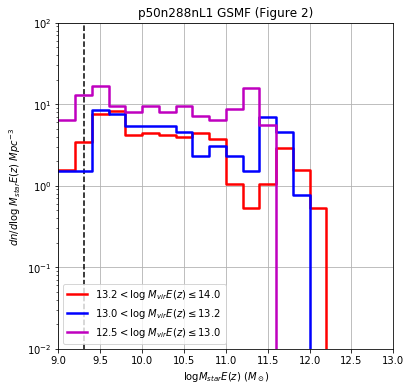

In [36]:
plt.figure(figsize=(6,6))
logbins = np.arange(9, 13.2, 0.2)
bin_width = logbins[1:]-logbins[:-1]
middle = logbins[1:]# + logbins[:-1])/2

hist3 = np.histogram(high_group_gal_logmass, bins=logbins)[0]/(high_volume*bin_width)
hist3forplt = np.append(hist3[0], hist3)
plt.plot(logbins, hist3forplt, drawstyle='steps', label=r'$13.2<\log$ $M_{vir}E(z)\leq 14.0$', color='r', linewidth=2.5)

hist2 = np.histogram(mid_group_gal_logmass, bins=logbins)[0]/(mid_volume*bin_width)
hist2forplt = np.append(hist2[0], hist2)
plt.plot(logbins, hist2forplt, drawstyle='steps', label=r'$13.0<\log$ $M_{vir}E(z)\leq 13.2$', color='b', linewidth=2.5)

hist1 = np.histogram(low_group_gal_logmass, bins=logbins)[0]/(low_volume*bin_width)
hist1forplt = np.append(hist1[0], hist1)
plt.plot(logbins, hist1forplt, drawstyle='steps', label=r'$12.5<\log$ $M_{vir}E(z)\leq 13.0$', color='m', linewidth=2.5)

# hist = np.histogram(galaxy_logM['star'], bins=logbins)[0]
# plt.plot(middle, hist/(vol2*bin_width))
plt.legend()
plt.yscale('log')
plt.xlim([9, 13])
plt.ylim([1e-2, 1e2])
plt.xlabel(r'$\log M_{star}E(z)$ $(M_\odot)$')
plt.ylabel(r'$dn/d\log$ $M_{star}E(z)$ $Mpc^{-3}$')
plt.title('p50n288' + shuiyao_type[num] + ' GSMF (Figure 2)')
plt.vlines(np.log10(galaxy_low_limit), 1e-2, 1e2, color='k', linestyle='dashed')
plt.grid()
#plt.savefig('/scratch/zwshao/Results/' + Save_filename + 'Figure2.pdf')
plt.show()
plt.close()